# load toy dataset

In [1]:
import numpy as np
import torch
# https://drive.google.com/file/d/1DLiN4dGxkQ_u_1MRNhwak2jj02_Q58fT/view?usp=sharing
# download data and put in root of directory

arr = torch.from_numpy(np.load('merged_array.npy'))
arr = arr.permute(1, 2, 0)

/data/mamba_envs/murschel/vdm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arr.shape

torch.Size([6016, 128, 202])

In [3]:
arr = arr.flatten(start_dim=0, end_dim=1)
arr.shape

torch.Size([770048, 202])

In [4]:
arr = arr.unsqueeze(0)
arr.shape

torch.Size([1, 770048, 202])

In [5]:
# dimension must be power of 2
# so 128 or 256
arr = arr[:, :, :128]
arr = arr.permute(1,0,2)
arr.shape

torch.Size([770048, 1, 128])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# load 1d unet / diffusion model from gh repo, create example train_sequence and train. create diffusion bases sample version 

In [7]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D 
# import torch dataset
from torch.utils.data import Dataset

model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 100,
    objective = 'pred_x0'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kirilm. Use `wandb login --relogin` to force relogin


In [8]:
model

Unet1D(
  (init_conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
    

In [9]:
#training_seq = torch.rand(1, 202, 32) # features are normalized from 0 to 1 # b, ch, seq_length
training_seq = arr

trainer = Trainer1D(
    diffusion,
    dataset = training_seq,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 1_000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)
trainer.train()

loss: 0.0263: 100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]

training complete


In [10]:
# after a lot of training

sampled_seq = diffusion.sample(batch_size = 1)
sampled_seq.shape

sampling loop time step: 100%|██████████| 100/100 [00:01<00:00, 75.21it/s]


torch.Size([1, 1, 128])

In [12]:
len(diffusion.noises_list2)

101

In [14]:
diffusion.noises_list2[0].shape

torch.Size([1, 1, 128])

In [15]:
diffusion.ddim_sample_deterministic(sampled_seq, shape=sampled_seq.shape)

ddim_deterministic


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [64] and input of shape [64, 128]

# compare sampled_seq to original array with euclidian distance

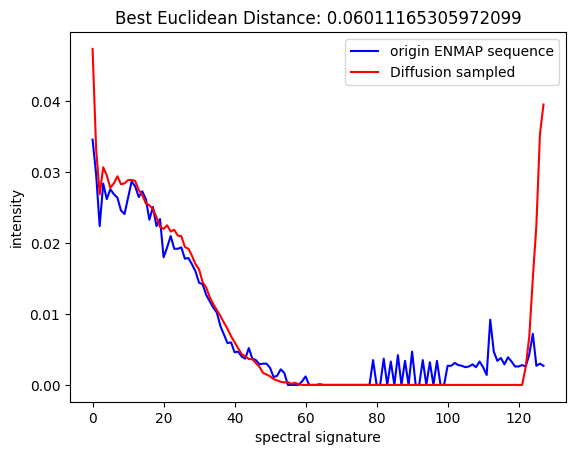

In [16]:
import matplotlib.pyplot as plt

# random pick of sampled sequence
diff_sampled = sampled_seq[0].cpu()

# Calculate the Euclidean distance (L2 norm) between seq1 and each row of seq2
distances = torch.linalg.norm(diff_sampled - arr, dim=-1)

min_value, min_idx = distances.min(dim=0)
max_value, max_idx = distances.max(dim=0)

plt.plot(arr[min_idx][0][0].numpy(), color='blue', label='origin ENMAP sequence')
plt.plot(diff_sampled.cpu()[0].numpy(), color='red', label='Diffusion sampled')
plt.xlabel('spectral signature')
plt.ylabel('intensity')
plt.legend()  # Display the legend
plt.title(f'Best Euclidean Distance: {min_value[0]}')
plt.show()  # Display the plot

In [ ]:
import matplotlib.pyplot as plt

# random pick of sampled sequence
diff_sampled = sampled_seq[1].cpu()

# Calculate the Euclidean distance (L2 norm) between arr1 and each row of arr2
distances = torch.linalg.norm(diff_sampled - arr, dim=-1)

min_value, min_idx = distances.min(dim=0)
max_value, max_idx = distances.max(dim=0)

plt.plot(arr[min_idx][0][0].numpy(), color='blue', label='origin ENMAP sequence')
plt.plot(diff_sampled.cpu()[0].numpy(), color='red', label='Diffusion sampled')
plt.xlabel('spectral signature')
plt.legend()  # Display the legend
plt.title(f'Best Euclidean Distance: {min_value[0]}')
plt.show()  # Display the plot

# histo

In [ ]:
import matplotlib.pyplot as plt

plt.hist(distances.detach().cpu().numpy(), bins=500)
plt.xlabel('Euclidian Distance')
plt.xlim(0,3)
plt.ylabel('Frequency')
plt.title('Histogram of Euclidian Distance')
plt.show()